In [1]:
import os
from datetime import datetime
from dataclasses import dataclass
import json


video_path = "../video_data"
image_path = "../data/ground_truth/cxl/full_images"
timestamps_path = "../data/derived_data/timestamps.json"

video_names = os.listdir(video_path)
image_names = os.listdir(image_path)
timestamps = json.load(open(timestamps_path))


@dataclass
class Video:
    camera_id: str
    date: datetime


@dataclass
class Image:
    gorilla_id: str
    camera_id: str
    data: datetime


def extract_video_info(video_name) -> Video:
    try:
        filename, _ = os.path.splitext(video_name)
        camera_id, date_str, _ = filename.split("_")
        date = datetime.strptime(date_str, "%Y%m%d")
        timestamp = timestamps[filename]
        daytime = datetime.strptime(timestamp, "%I:%M %p")
        date = datetime.combine(date, daytime.time())
    except ValueError:
        print(f"Could not parse {video_name}")
        return None
    return Video(camera_id, date)


def extract_image_info(image_name) -> Image:
    try:
        gorilla_id, camera_id, date_str, _ = image_name.split("_")
        date = datetime.strptime(date_str, "%Y%m%d")
        return Image(gorilla_id, camera_id, date)
    except ValueError:
        print(f"Could not parse {image_name}")
        return None


videos = list(filter(lambda v: v is not None, map(extract_video_info, video_names)))
images = list(filter(lambda i: i is not None, map(extract_image_info, image_names)))

camera_ids = set(map(lambda v: v.camera_id, videos))
gorilla_ids = set(map(lambda i: i.gorilla_id, images))

Could not parse .mp4
Could not parse YE01_R035_20191012_079 _son.png
Could not parse GR01_R065_20181202_328gr_son.png


In [2]:
print(f"Found {len(videos)} videos")
print(f"Found {len(images)} images")
print(f"Found {len(camera_ids)} camera ids")
print(f"Found {len(gorilla_ids)} gorilla ids")

Found 12424 videos
Found 950 images
Found 40 camera ids
Found 119 gorilla ids


# Video Analytics

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import pandas as pd
import numpy as np

### Datetime

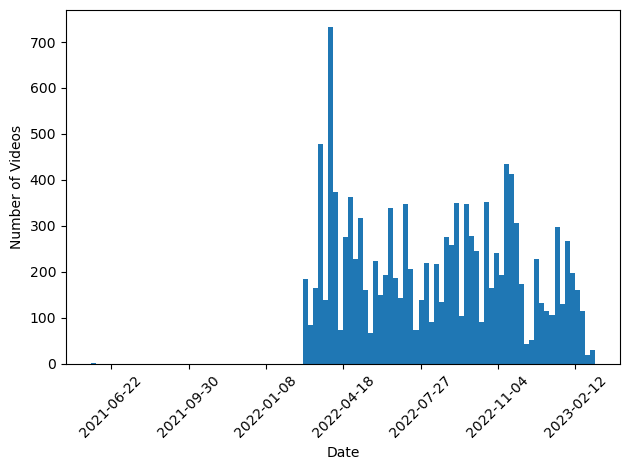

In [4]:
video_dates = [v.date.date() for v in videos]
video_dates_matplotlib = [mdates.date2num(d) for d in video_dates]
fig, ax = plt.subplots()
ax.hist(video_dates_matplotlib, bins=100)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
# plt.yscale("log")
plt.xlabel("Date")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

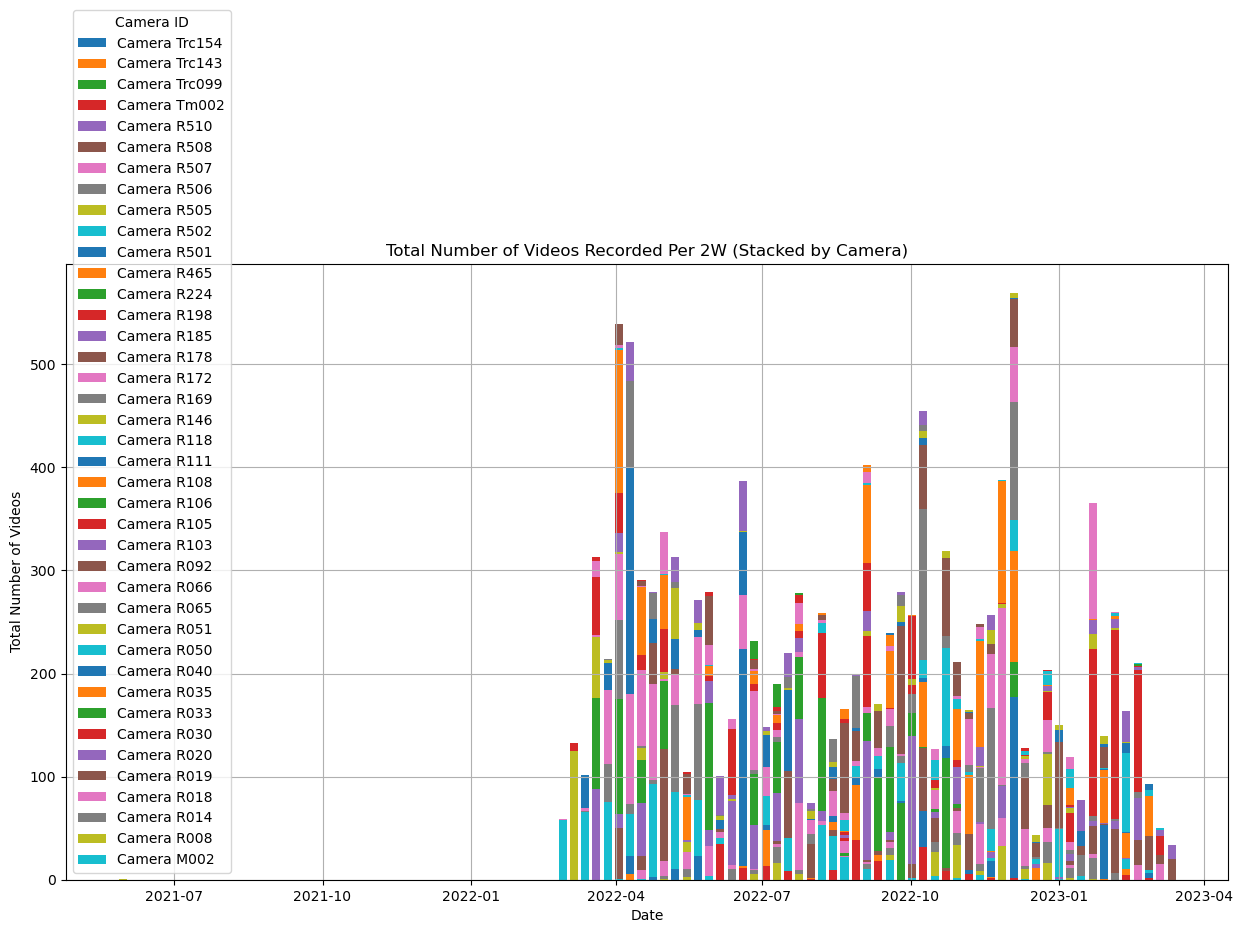

In [5]:
BIN_SIZE_IN_WEEKS = 2
bin_size = f"{BIN_SIZE_IN_WEEKS}W"
video_data = [(v.camera_id, v.date.date()) for v in videos]
df_videos = pd.DataFrame(video_data, columns=["camera_id", "date"])
df_videos["date"] = pd.to_datetime(df_videos["date"])

grouped_data = df_videos.groupby("camera_id").resample(bin_size, on="date").size().reset_index(name="count")
pivot_data = grouped_data.pivot(index="date", columns="camera_id", values="count").fillna(0)
stacked_data = pivot_data.cumsum(axis=1)

stacked_data

# Plotting
plt.figure(figsize=(15, 8))

bottom = np.zeros(len(stacked_data))

bin_width = 5

for camera_id in reversed(stacked_data.columns):
    plt.bar(
        stacked_data.index,
        stacked_data[camera_id],
        bottom=bottom,
        width=bin_width,
        align="center",
        label=f"Camera {camera_id}",
    )

plt.xlabel("Date")
plt.ylabel("Total Number of Videos")
plt.title(f"Total Number of Videos Recorded Per {bin_size} (Stacked by Camera)")
plt.legend(title="Camera ID")
plt.grid(True)
plt.show()

### If we not plot video files but videos taken on the same day

In [6]:
from collections import defaultdict

# Group videos by camera ID and date
grouped_videos = defaultdict(list)
for video in videos:
    grouped_videos[(video.camera_id, video.date.date())].append(video)

# Find start and end times for each group
video_group_timings = {}
for (camera_id, date), group in grouped_videos.items():
    start_time = min(video.date for video in group)
    end_time = max(video.date for video in group)
    video_group_timings[(camera_id, date)] = (start_time, end_time, end_time - start_time)

len(grouped_videos), len(videos)

(1122, 12424)

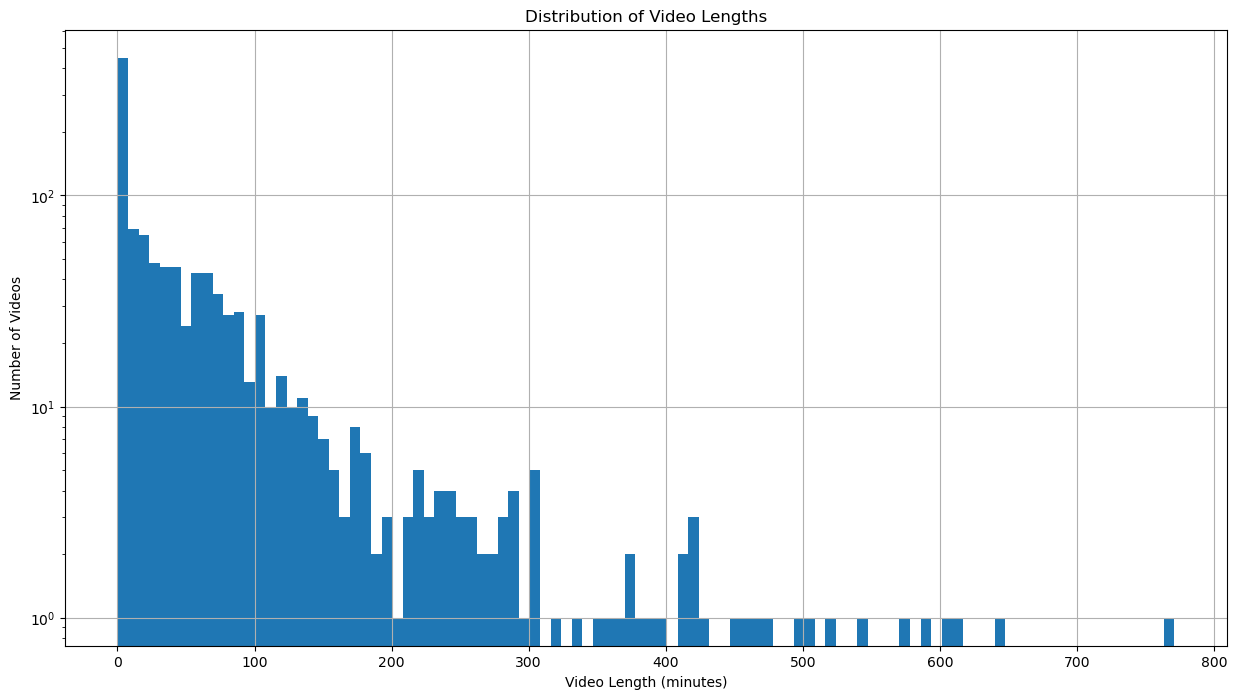

In [7]:
plt.figure(figsize=(15, 8))
plt.hist([length.total_seconds() / 60 for _, __, length in video_group_timings.values()], bins=100, log=True)
plt.xlabel("Video Length (minutes)")
plt.ylabel("Number of Videos")
plt.title("Distribution of Video Lengths")
plt.grid(True)
plt.show()

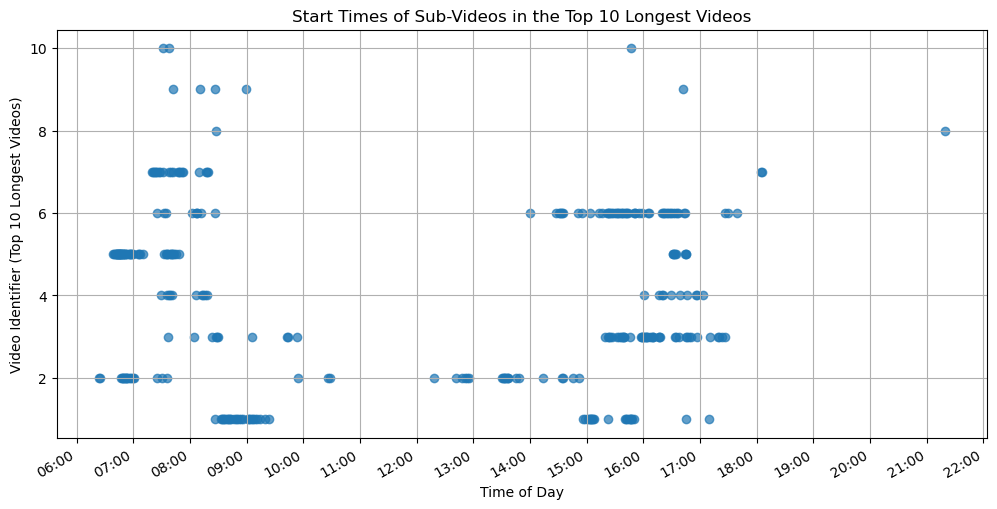

In [8]:
longest_videos_time = sorted(video_group_timings.values(), key=lambda x: x[2], reverse=True)[:10]
_, __, length = longest_videos_time[-1]
# get the key for the longest videos
longest_videos = [key for key, value in video_group_timings.items() if value[2] >= length]

scatter_data = []
for index, key in enumerate(longest_videos):
    for video in grouped_videos[key]:
        time = video.date.time()
        scatter_data.append((mdates.date2num(datetime.combine(datetime.min, time)), index + 1))

# Separate the data for plotting
times, video_indices = zip(*scatter_data)

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(times, video_indices, alpha=0.7)

# Formatting the x-axis to show time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Interval set to every hour
plt.gcf().autofmt_xdate()  # Auto-format for better readability

# Set labels and title
plt.xlabel("Time of Day")
plt.ylabel("Video Identifier (Top 10 Longest Videos)")
plt.title("Start Times of Sub-Videos in the Top 10 Longest Videos")
plt.grid(True)

# Show plot
plt.show()

### Time of day the videos were taken

In [9]:
times = [v.date.time() for v in videos]

times_matplotlib = [mdates.date2num(datetime.combine(datetime.today(), t)) for t in times]

fig, ax = plt.subplots()
ax.hist(times_matplotlib, bins=24 * 4, rwidth=0.8)  # 24 bins for each hour of the day

# Format the x-axis to display hours
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

plt.xlabel("Time of Day")
plt.ylabel("Number of Videos")
plt.title("Distribution of Video Recording Times")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Image Analytics

### Datetime

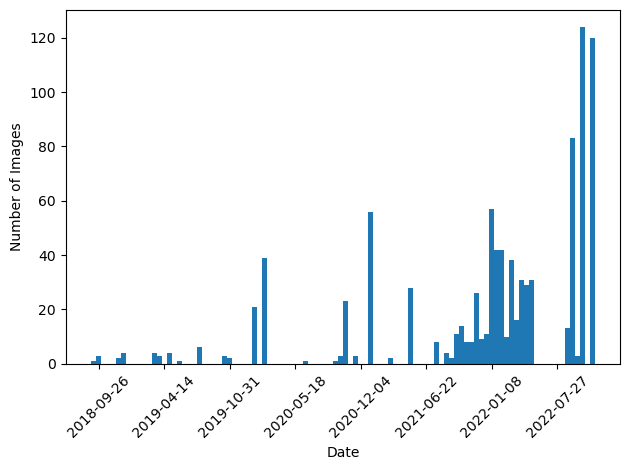

In [ ]:
# Extracting dates from the images data
image_dates = [i.data.date() for i in images]
image_dates_matplotlib = [mdates.date2num(d) for d in image_dates]

# Histogram of image dates
fig, ax = plt.subplots()
ax.hist(image_dates_matplotlib, bins=100)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xlabel("Date")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of pictures among gorillas

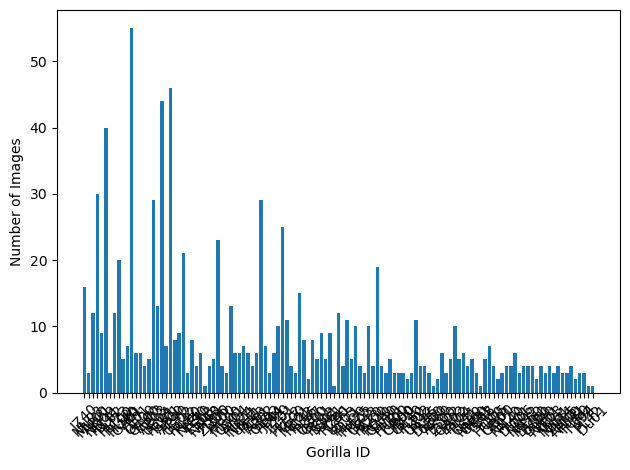

In [ ]:
gorilla_image_count = {}
for i in images:
    gorilla_image_count[i.gorilla_id] = gorilla_image_count.get(i.gorilla_id, 0) + 1

fig, ax = plt.subplots()
ax.bar(gorilla_image_count.keys(), gorilla_image_count.values())
plt.xlabel("Gorilla ID")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Images per camera ID

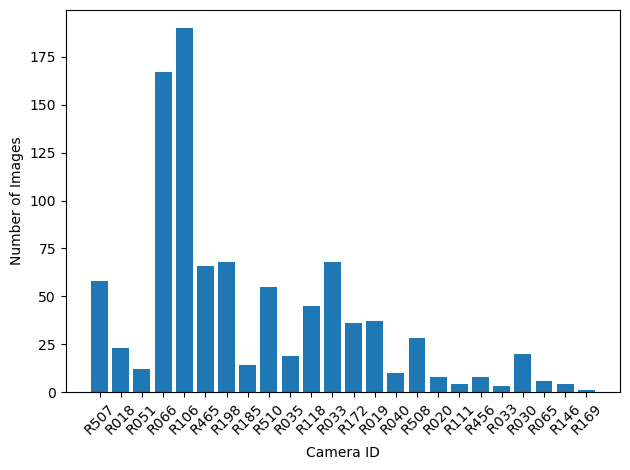

In [ ]:
camera_image_count = {}
for i in images:
    camera_image_count[i.camera_id] = camera_image_count.get(i.camera_id, 0) + 1

fig, ax = plt.subplots()
ax.bar(camera_image_count.keys(), camera_image_count.values())
plt.xlabel("Camera ID")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Image and Videos Compared

<Figure size 1500x800 with 0 Axes>

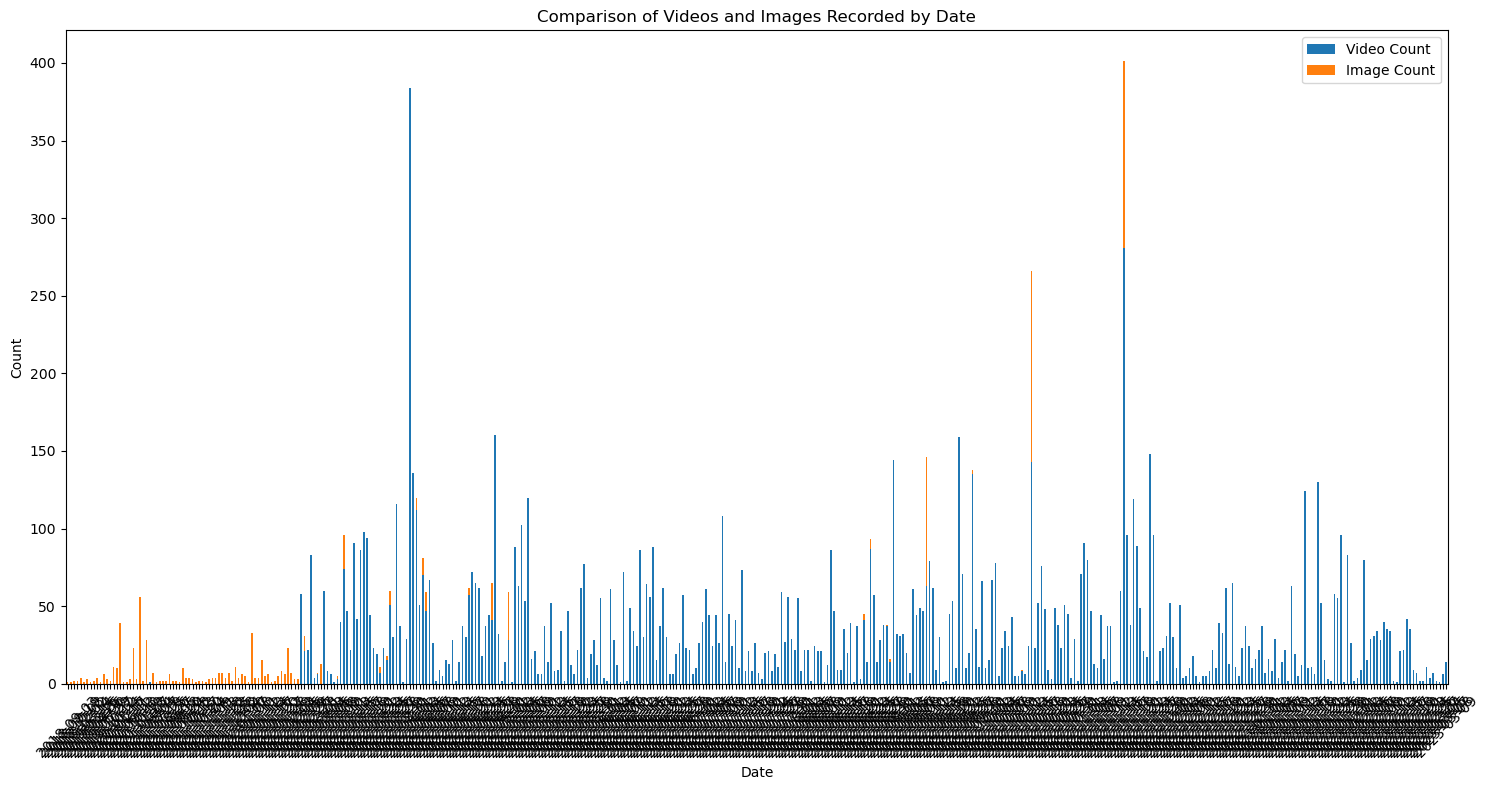

In [ ]:
from collections import Counter

# Counting the number of videos and images for each date
video_date_counts = Counter([video.date.date() for video in videos])
image_date_counts = Counter([image.data.date() for image in images])

# Create a DataFrame from the counts
df_video_image = pd.DataFrame(
    {"Video Count": pd.Series(video_date_counts), "Image Count": pd.Series(image_date_counts)}
)

# Fill missing dates in each series with 0
df_video_image = df_video_image.fillna(0)

# Sort the DataFrame by date
df_video_image = df_video_image.sort_index()

# Plotting
plt.figure(figsize=(15, 8))
# Stacked bar chart
df_video_image.plot(kind="bar", stacked=True, figsize=(15, 8))

plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Comparison of Videos and Images Recorded by Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()